In [1]:
# 之前章节定义的函数
%matplotlib inline
import random
import math
import torch
import collections
import re
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# d2l不包含的函数，一次性可以复制这个cell
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine(): #@save
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token = 'word'): #@save
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('tokenize类型输入错误')

class Vocab: #@save
    # 创建这个Vocab语料库，我们的目的是创建一个 idx_to_token表示所有token，token_to_idx，通过token找下标
    def __init__(self, tokens = None, min_freq = 0, reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按照出现频率排序,接下来我们先去写 count_corpus
        counter = count_corpus(tokens)
        # 我们拿到了counter，是一个字典，包含了token和出现的次数，接下来要排序
        # sorted(iterable, key, reverse)
        self._token_freqs = sorted(counter.items(), key = lambda x:x[1], reverse=True) # lamda x:x[1]表示按照x[1]排列
        # 未知词元的索引为0
        # 初始化
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            # 这是一个字典表达式
            token:idx for idx,token in enumerate(self.idx_to_token)
        }
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx: # 1.token_to_idx 是字典，查找更快 2.会默认把token当做key查找
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
                
    # 接下来我们要构造一些魔术方法，因为普通len不能返回这个Vocab的长度
    # 比如，我们可能要写 len(Vocab.idx_to_token)
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens): # 在执行 obj[key]的时候就会被触发, 比如 vocab[token[i]]
        if not isinstance(tokens, (list, tuple)): # 如果tokens又不是list又不是tuple
            return self.token_to_idx.get(tokens, self.unk) # 那就直接去找，没找到就 self.unk
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[indice] for indice in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
                
def count_corpus(tokens):
    # 数 语料 的个数
    # tokens 可以是 1d,可以是2d
    if len(tokens) == 0 or all(isinstance(token, list) for token in tokens):
        # 我们要把2d展开成1d
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens) # counter方法可以把一个列表变成字典，以出现次数的形式

def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 展平，应为一行不一定是一句完整的话
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # corpus:序列
    # batch_size:batch的数量
    # num_steps:每一组数据的跨度，人为定义的，每一组数据之间一定有这么大的跨度
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1) : ]
    num_subseqs = (len(corpus) - 1) // num_steps # 代表一共会有几个子串 
    # len - 1是因为 找一组X,还要找一组Y = X + 1，给Y留出位置
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos : pos + num_steps]

    # num_batches表示你现在有subseqs组可以拿，那我一组要batch个，我能拿多少组呢
    num_batches = num_subseqs // batch_size
    # print('lencorpus', len(corpus),'\n')
    # print('num_subseqs:', num_subseqs,'\n')
    # print('num_batches:', num_batches,'\n')
    # print('initial_indices:', initial_indices,'\n')
    for i in range(0 ,num_batches * batch_size, batch_size):
        initial_indices_per_batch = initial_indices[i : i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)
        # yield能让函数成为生成器，每次输出完可以暂停执行，指到下一次被调用

def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_seqs = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_seqs])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_seqs])
    Xs, Ys = Xs.reshape((batch_size, -1)), Ys.reshape((batch_size, -1))
    num_batches = Xs.shape[1] // num_steps
    # print(Xs.shape[1])
    # print(num_seqs)
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
        
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [3]:
# 独热编码，假设一共有N个词元数目，我们创建一个N的全0向量，把第i位设置为1

F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
# 我们每次采样的小批量数据形状是二维张量： （批量大小，时间步数）。 
# one_hot函数将这样一个小批量数据转换成三维张量， 张量的最后一个维度等于词表大小（len(vocab)）。 
# 我们经常转换输入的维度，以便获得形状为 （时间步数，批量大小，词表大小）的输出。 
# 这将使我们能够更方便地通过最外层的维度， 一步一步地更新小批量数据的隐状态。

In [5]:
# 时间步数，在这里就表示长度
X = torch.arange(10).reshape(2,-1)
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [6]:
# 接下来，我们初始化循环神经网络模型的模型参数。 
# 隐藏单元数num_hiddens是一个可调的超参数。 当训练语言模型时，输入和输出来自相同的词表。 
# 因此，它们具有相同的维度，即词表的大小。

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device) # O = Ht * Whq
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [7]:
# 为了定义循环神经网络模型， 我们首先需要一个init_rnn_state函数在初始化时返回隐状态。 
# 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）。 
# 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

##### 解释一下这个命名怎么来的
##### 1.W_xh x表示input,输入;h表示hidden，隐藏;q表示output,q类别,输出
##### 2.所以可显而易见的,W_hh = hidden to hidden,W_hq: hidden to output

In [8]:
# 下面的rnn函数定义了如何在一个时间步内计算隐状态和输出。 
# 循环神经网络模型通过inputs最外层的维度实现循环， 以便逐时间步更新小批量数据的隐状态H。

def rnn(inputs, state, params): # state包含上一层的隐函数内容
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state # 单个的解包操作，state需要是一个单元素的可迭代的容器，这样就可以解包给H
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(X @ W_xh + H @ W_hh + b_h)
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [9]:
# 定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数， 并存储从零开始实现的循环神经网络模型的参数。

In [10]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state): # 我没有继承 nn.module，所以没有call方法来实现 output = model(X)的前向传播
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [11]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                     init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape # 前面 X 是 batch 2 步数 5

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [12]:
# 让我们首先定义预测函数来生成prefix之后的新字符， 其中的prefix是一个用户提供的包含多个字符的字符串。 
# 在循环遍历prefix中的开始字符时， 我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。 
# 这被称为预热（warm-up）期， 因为在此期间模型会自我更新（例如，更新隐状态）， 但不会进行预测。 
# 预热期结束后，隐状态的值通常比刚开始的初始值更适合预测， 从而预测字符并输出它们。

def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    # lambda 是一个匿名函数，用来方便的定义局内使用的函数
    # 等效于：def get_input(): 巴拉巴拉
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1,1))
    # 预热，我只要 state,不要预测值
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # 预测
    for y in range(num_preds):
        y, state = net(get_input(), state) # y的形状是(batch_size * 时间步长, num_class)
        outputs.append(int(y.argmax(dim=1).reshape(1,-1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [13]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller oanananana'

In [14]:
# 对于长度为T的序列，我们在迭代中计算这T个时间步上的梯度， 将会在反向传播过程中产生长度为OT的矩阵乘法链
# 它可能导致数值不稳定， 例如可能导致梯度爆炸或梯度消失。 因此，循环神经网络模型往往需要额外的方式来支持稳定训练。
# 梯度裁剪提供了一个快速修复梯度爆炸的方法， 虽然它并不能完全解决问题，但它是众多有效的技术之一。

def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params # 那我就假设你自己自定义的网络有一个params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params)) # 就是在算L2范数
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [15]:
# 在训练模型之前，让我们定义一个函数在一个迭代周期内训练模型
# 它与我们训练 3.6节模型的方式有三个不同之处。
# 1.序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
# 2.我们在更新模型参数之前裁剪梯度。 这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散
# 3.我们用困惑度来评价模型。
# 具体来说，当使用顺序分区时， 我们只在每个迭代周期的开始位置初始化隐状态。
# 当使用随机抽样时，因为每个样本都是在一个随机位置抽样的， 因此需要为每个迭代周期重新初始化隐状态。

In [16]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        # 在RNN中，我们不希望state在反向传播的时候被更新，因为state不需要被反向传播更新
        # state @ Whh 得到的当前层的隐藏层输出, state是一个取决于预测时文本的状态，学习没有用
        # 所以我们要detach掉
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state 对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel()) # numel:number of elements
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [17]:
i = 1
for X, Y in train_iter:
    if i >= 2:
        break
    else:
        i += 1
        print(X)
        print(X.shape)
        print("分割")
        print(Y)

tensor([[ 2,  1,  3,  ..., 21,  2,  1],
        [ 1,  4,  6,  ...,  4,  5, 10],
        [ 4,  3,  1,  ...,  6,  2,  8],
        ...,
        [ 1, 15,  7,  ...,  1, 21, 14],
        [15, 10, 19,  ..., 13, 14,  8],
        [ 2,  1, 13,  ...,  5, 10,  1]])
torch.Size([32, 35])
分割
tensor([[ 1,  3,  5,  ...,  2,  1, 15],
        [ 4,  6, 11,  ...,  5, 10,  8],
        [ 3,  1,  4,  ...,  2,  8,  8],
        ...,
        [15,  7,  6,  ..., 21, 14,  3],
        [10, 19,  8,  ..., 14,  8,  3],
        [ 1, 13,  2,  ..., 10,  1,  4]])


In [18]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.1, 83052.4 词元/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


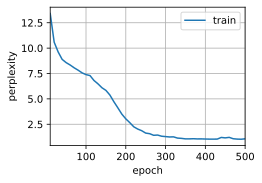

In [19]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 66528.4 词元/秒 cuda:0
time traveller proceeded anyreal body must have extension in fou
travellerit s against reason said filbycan a cube that does


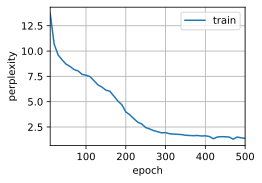

In [20]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)